# Imports

In [1]:
import numpy    as np
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt
import sklearn  as skl
import time
from IPython.display import clear_output

from sklearn import pipeline      # Pipeline, make_pipeline
from sklearn import preprocessing # StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn import impute
from sklearn import compose
from sklearn import model_selection # train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import inspection      # permutation_importance
import scikitplot as skplt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sb.set_style("whitegrid")
skl.set_config(display='diagram')

print("Pandas  ", pd.__version__)
print("Sklearn ", skl.__version__)

Pandas   1.2.0
Sklearn  0.23.2


In [2]:
########################################################### CLASSIFIERS

#### MULT
from sklearn.linear_model   import LogisticRegression
from sklearn.linear_model   import RidgeClassifier
from sklearn.svm            import SVC
from sklearn.svm            import NuSVC
from sklearn.svm            import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes    import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble       import StackingClassifier

#### TREE
from sklearn.tree          import DecisionTreeClassifier
from sklearn.ensemble      import RandomForestClassifier
from sklearn.ensemble      import ExtraTreesClassifier
from sklearn.ensemble      import AdaBoostClassifier
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.experimental  import enable_hist_gradient_boosting
from sklearn.ensemble      import HistGradientBoostingClassifier
from xgboost               import XGBClassifier, plot_tree
from lightgbm              import LGBMClassifier
from catboost              import CatBoostClassifier
#from ngboost               import NGBClassifier
#from rgf.sklearn           import RGFClassifier, FastRGFClassifier

########################################################### REGRESSORS
from sklearn.linear_model  import ElasticNet, Ridge, Lasso, BayesianRidge, ARDRegression, TweedieRegressor
from sklearn.svm           import LinearSVR, NuSVR, SVR
from sklearn.ensemble      import BaggingRegressor
from sklearn.kernel_ridge  import KernelRidge

# DATA

### Read data

In [3]:
df      = pd.read_csv("../datasets/titanic_train.csv", index_col='PassengerId')
df_test = pd.read_csv("../datasets/titanic_test.csv",  index_col='PassengerId')

### Feature Generation

In [4]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

df['Title'] = df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
df['Title'] = df.Title.map(Title_Dictionary)
df['Title'].value_counts()

Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      5
Name: Title, dtype: int64

In [5]:
df_test['Title'] = df_test['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
df_test['Title'] = df_test.Title.map(Title_Dictionary)
df_test['Title'].value_counts()

Mr         240
Miss        78
Mrs         73
Master      21
Officer      5
Name: Title, dtype: int64

In [6]:
df.groupby(['Sex','Pclass','Title']).Age.agg(["mean","median","count"]).reset_index(drop=False)

,Sex,Pclass,Title,mean,median,count
0,female,1,Miss,29.744681,30.0,47
1,female,1,Mrs,40.400000,40.0,35
2,female,1,Officer,49.000000,49.0,1
3,female,1,Royalty,40.500000,40.5,2
4,female,2,Miss,22.390625,24.0,32
5,female,2,Mrs,33.547619,31.5,42
6,female,3,Miss,16.123188,18.0,69
7,female,3,Mrs,33.515152,31.0,33
8,male,1,Master,5.306667,4.0,3
9,male,1,Mr,41.580460,40.0,87


In [7]:
imp = GroupImputer(group_cols=['Sex','Pclass','Title'], target='Age', metric='mean')

df_imp = pd.DataFrame(imp.fit_transform(df), columns=df.columns)

NameError: name 'GroupImputer' is not defined

In [8]:
df_imp

NameError: name 'df_imp' is not defined

In [9]:
#https://towardsdatascience.com/coding-a-custom-imputer-in-scikit-learn-31bd68e541de
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class GroupImputer(BaseEstimator, TransformerMixin):

    def __init__(self, group_cols, target, metric='mean'):
        
        assert metric in ['mean', 'median'], 'Unrecognized value for metric, should be mean/median'
        assert type(group_cols) == list, 'group_cols should be a list of columns'
        assert type(target) == str, 'target should be a string'
        
        self.group_cols = group_cols
        self.target = target
        self.metric = metric
    
    def fit(self, X, y=None):
        
        print(X.shape)
        
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, 'There are missing values in group_cols'
        
        impute_map = X.groupby(self.group_cols)[self.target].agg(self.metric).reset_index(drop=False)
        
        self.impute_map_ = impute_map
        
        return self 
    
    def transform(self, X, y=None):
        
        check_is_fitted(self, 'impute_map_') # make sure that the imputer was fitted
        
        X = X.copy()
        
        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind] = X.loc[ind].fillna(row[self.target])
        
        return X[[self.target]].values

### Select data for experiment

In [10]:
x = df.drop(columns=["Survived", 'Name', 'Ticket', 'Cabin']) # X DATA (WILL BE TRAIN+VALID DATA)
y = df["Survived"] # 0 = No, 1 = Yes

x_test = df_test.drop(columns=['Name', 'Ticket', 'Cabin']) # # X_TEST DATA (NEW DATA)

# PREPROCESSING

### Select numerical and categorical variables

In [11]:
cat_vars  = ['Sex', 'Embarked', 'Title']         # x.select_dtypes(include=[object]).columns.values.tolist()
num_vars  = ['Pclass', 'SibSp', 'Parch', 'Fare'] # x.select_dtypes(exclude=[object]).columns.values.tolist()
age_var   = ['Age', 'Sex', 'Pclass', 'Title']    # Imputate age by mean of grouping ['Sex', 'Pclass', 'Title']

print("\nNumerical features:\n", num_vars)
print("\nCategorical features:\n", cat_vars)


Numerical features:
 ['Pclass', 'SibSp', 'Parch', 'Fare']

Categorical features:
 ['Sex', 'Embarked', 'Title']


### Preprocessing for Mult Models

In [12]:
num_4_multModels = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean', add_indicator=True)), # mean, median
    ('scaler', preprocessing.StandardScaler())
])

cat_4_multModels = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', preprocessing.OneHotEncoder(handle_unknown='ignore'))
])

age_4_multModels = pipeline.Pipeline(steps=[
    ('imputer', GroupImputer(group_cols=['Sex','Pclass','Title'], target='Age', metric='mean')),
    ('scaler', preprocessing.StandardScaler())
])

mult_prepro = compose.ColumnTransformer(transformers=[
    ('num', num_4_multModels, num_vars),
    ('cat', cat_4_multModels, cat_vars),
    ('age', age_4_multModels, age_var),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

mult_prepro

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True)),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex', 'Embarked', 'Title']),
                                ('age',
                                 Pipeline(steps=[('imputer',
                                                  GroupImputer(group_cols=['Sex',
                                                                           'Pclass',
                                                                           'Title'],
                                                               target='Age')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'Sex', 'Pclass', 'Title'])])

### Preprocessing for Tree Models

In [13]:
num_4_treeModels = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value=-9999)),
])

cat_4_treeModels = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', preprocessing.OrdinalEncoder()) # handle_unknown='ignore' ONLI IN VERSION 0.24
])

age_4_treeModels = pipeline.Pipeline(steps=[
    ('imputer', GroupImputer(group_cols=['Sex','Pclass','Title'], target='Age', metric='mean')),
])

tree_prepro = compose.ColumnTransformer(transformers=[
    ('num', num_4_treeModels, num_vars),
    ('cat', cat_4_treeModels, cat_vars),
    ('age', age_4_treeModels, age_var),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

tree_prepro

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=-9999,
                                                                strategy='constant'))]),
                                 ['Pclass', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Sex', 'Embarked', 'Title']),
                                ('age',
                                 Pipeline(steps=[('imputer',
                                                  GroupImputer(group_cols=['Sex',
                                                                           'Pclass',
                                                                           'Title'],
                                                               target='Age'))]),
                                 ['Age', 'Sex', 'Pclass', 'Title'])])

# Models

In [14]:
"""
ensemble = [
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
    make_pipeline(StandardScaler(), RidgeClassifier()),
    make_pipeline(StandardScaler(), LinearSVC(random_state=42))
]

ensemble2 = [
    ('RF',    RandomForestClassifier(n_estimators=50, random_state=42)),
    ("Ridge", make_pipeline(StandardScaler(), RidgeClassifier())),
    ("SVM_rbf", make_pipeline(StandardScaler(), SVC(kernel='linear')))
]
"""

mult_classifiers = {
  #"Stacking":       StackingClassifier(estimators=ensemble2, final_estimator=LogisticRegression()),
  "LogRegr ":        LogisticRegression(),
  "Ridge":           RidgeClassifier(),
  "SVM_lin":         SVC(kernel="linear"), # C=0.025
  "SVM_rbf":         SVC(kernel='rbf'),
  "NuSVC":           NuSVC(),
  "LinearSVC":       LinearSVC(),
  "KNN3":            KNeighborsClassifier(3),
  "KNN5":            KNeighborsClassifier(5),
# "GP":              GaussianProcessClassifier(1.0 * RBF(1.0)),
# "GaussianNB":      GaussianNB()
}

tree_classifiers = {
  "Decision Tree": DecisionTreeClassifier(),
  "Extra Trees":   ExtraTreesClassifier(n_estimators=100),
  "Random Forest": RandomForestClassifier(n_estimators=100),
  "AdaBoost":      AdaBoostClassifier(n_estimators=100),
  "Skl GBM":       GradientBoostingClassifier(n_estimators=100),
  "Skl HistGBM":   HistGradientBoostingClassifier(),
  "XGBoost":       XGBClassifier(n_estimators=100),
  "LightGBM":      LGBMClassifier(n_estimators=100),
  "CatBoost":      CatBoostClassifier(n_estimators=100),
# "NGBoost":       NGBClassifier(n_estimators=100),
# "RGF":           RGFClassifier(n_jobs=-1),
# "FastRGF":       FastRGFClassifier())
}


mult_classifiers = {name: pipeline.make_pipeline(mult_prepro, model) for name, model in mult_classifiers.items()}
tree_classifiers = {name: pipeline.make_pipeline(tree_prepro, model) for name, model in tree_classifiers.items()}

models = {**mult_classifiers, **tree_classifiers} # mult_classifiers | tree_classifiers  IN PYTHON 3.9+

In [15]:
mult_regressors = {
  "lasso":          Lasso(     alpha = 1, normalize = False, max_iter = 5000, tol = 1e-5),
  "ridge":          Ridge(     alpha = 1, normalize = False, max_iter = 5000, tol = 1e-5),
  "elastic_net":    ElasticNet(alpha =1, normalize = False, max_iter = 5000, tol = 1e-5, l1_ratio = 0.5),
  "bagging_regr":   BaggingRegressor(Ridge(alpha=1), n_estimators=100, random_state=42, max_samples=3, max_features=6),
  "bayesian_ridge": BayesianRidge(n_iter=1000, tol=10e-05),
  "ard_regression": ARDRegression(),
  "kernel_ridge":   KernelRidge(alpha=1, kernel='rbf'),
  "linear_svr":     LinearSVR(C=1),
  "svr":            SVR(C=1, cache_size=3000.0),
  "nusvr":          NuSVR(nu=1, C=1),
  "GLM power0":     TweedieRegressor( power = 0, alpha = 1),
  "GLM power1":     TweedieRegressor( power = 1, alpha = 1),
  "GLM power2":     TweedieRegressor( power = 2, alpha = 1)
}

# Do the experiment

In [16]:
preds = {}
skf = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})

for name, model in models.items():    
        
    start_time = time.time()
    pred = model_selection.cross_val_predict(model, x, y, cv=skf)
    total_time = time.time() - start_time
    
    preds[name] = pred
    results = results.append({"Model":    name,
                              "Accuracy": metrics.accuracy_score(y, pred)*100,
                              "Bal Acc.": metrics.balanced_accuracy_score(y, pred)*100,
                              "Time":     total_time},
                              ignore_index=True)
    
    results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
    results_ord.index += 1 

    clear_output(wait=True)
    display(results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d'))

,Model,Accuracy,Bal Acc.,Time
1,Skl GBM,83.389450,81.284153,1.716500
2,NuSVC,83.052750,81.176301,1.231742
3,LinearSVC,83.052750,81.451922,1.341946
4,Ridge,82.940516,81.305723,1.100482
5,SVM_rbf,82.828283,80.608283,1.195999
6,LogRegr,82.716049,81.233822,1.209718
7,SVM_lin,82.716049,81.013326,1.207395
8,LightGBM,82.491582,80.776052,1.542664
9,Skl HistGBM,82.267116,80.593903,2.966230
10,CatBoost,82.267116,79.822165,2.048267


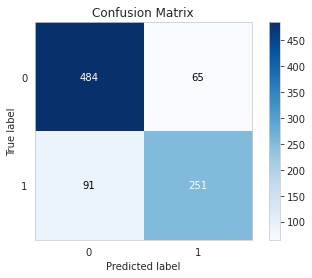

In [19]:
skplt.metrics.plot_confusion_matrix(y, preds["LightGBM"], normalize=False);

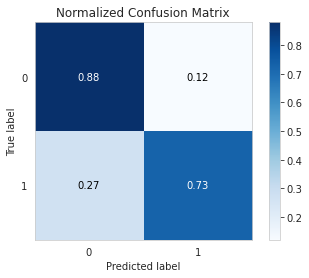

In [20]:
skplt.metrics.plot_confusion_matrix(y, preds["LightGBM"], normalize=True);

In [21]:
preds_df = pd.DataFrame(preds, index=df.index)
preds_df["Target"] = y
preds_df.head()

,LogRegr,Ridge,SVM_lin,SVM_rbf,NuSVC,LinearSVC,KNN3,KNN5,Decision Tree,Extra Trees,Random Forest,AdaBoost,Skl GBM,Skl HistGBM,XGBoost,LightGBM,CatBoost,Target
PassengerId,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,0,1,1,1,0,1,1,1,1,0,0,0,0,0,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

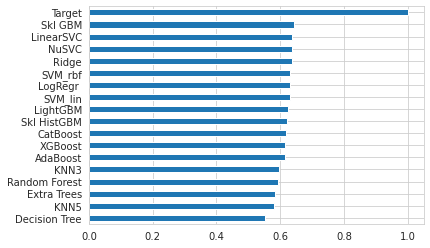

In [22]:
preds_df.corr().Target.sort_values().plot.barh()

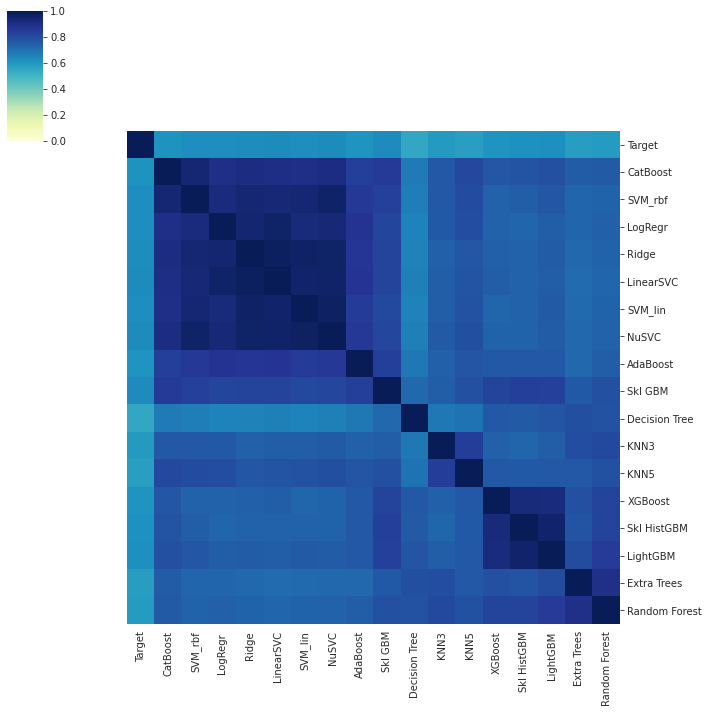

In [23]:
g= sb.clustermap(preds_df.corr(), cmap="YlGnBu", vmin=0, vmax=1)
g.ax_row_dendrogram.remove()
g.ax_col_dendrogram.remove()

In [24]:
final_model = models["SVM_rbf"]
final_model.fit(x,y)

(891, 4)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pclass', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked', 'Title']),
                                                 ('age',
                                                  Pipeline(steps=[('imputer',
                                                                   GroupImputer(group_cols=['Sex',
                                                                                            'Pclass',
                                                                                            'Title'],
                                                                                target='Age')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Sex', 'Pclass',
                                                   'Title'])])),
                ('svc', SVC())])

In [26]:
test_pred = final_model.predict(x_test)
test_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [27]:
sub = pd.DataFrame(test_pred, index=x_test.index, columns=["Survived"])
sub.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [28]:
sub.to_csv("Titanic_sub.csv")